In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import sys; sys.path.append("../")

import pickle
from netdataio import * 

from tqdm import tqdm_notebook as tqdm
import netdataio



from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors as rdMD

Populating the interactive namespace from numpy and matplotlib
sklearn.utils importing numpy
sklearn.utils done importing numpy
about to import murmurhash3
done with murmurhash
done with validation


/data/jonas/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/jonas/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/jonas/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [277]:
dataset = pickle.load(open("../graph_conv_many_nuc_pipeline.datasets/graph_conv_many_nuc_pipeline.data.13C_1H.nmrshiftdb_hconfspcl_nmrshiftdb.aromatic.64.0.mol_dict.pickle", 'rb'))

train_df = dataset['train_df']
train_df['phase'] = 'train'
test_df = dataset['test_df']
test_df['phase'] = 'test'
all_df = pd.concat([train_df, test_df])



m = train_df.iloc[0].rdmol
atoms = np.concatenate([[a.GetSymbol() for a in m.GetAtoms()] for m in train_df.rdmol])

print("unique atoms", np.unique(atoms))



unique atoms ['C' 'Cl' 'F' 'H' 'N' 'O' 'P' 'S']


In [278]:
model_filename = "../checkpoints/13C_1H_nmrshiftdb_hconfspcl_nmrshiftdb_64_graph_conv_GraphVert_9_1024_1024_False_0.0_64_0.001_0.001_True_0.99_1e-09_37_True_0.01_2.0_True.09923220"
meta_filename = f"{model_filename}.meta"


In [279]:
meta = pickle.load(open(meta_filename, 'rb'))
meta.keys()

dict_keys(['feat_vect_args', 'feat_mat_args', 'adj_args', 'init_noise', 'tgt_nucs', 'lr', 'MAX_N', 'STD_POW', 'BATCH_SIZE', 'USE_RESNET', 'INIT_NOISE', 'SPECT_SET', 'INT_D', 'AGG_FUNC', 'FORCE_LIN_INIT', 'data_feat', 'train_filename', 'g_feature_n', 'model_name', 'LAYER_N', 'USE_STD', 'STD_REG', 'loss_scale', 'std_scale'])

In [280]:

data_feat = meta['data_feat']
MAX_N = meta['MAX_N']

SINGLE_VALUE = False
COMBINE_MAT_VECT='row'

BATCH_SIZE = 32

feat_vect_args = meta['feat_vect_args']
feat_mat_args = meta['feat_mat_args']


adj_args = meta['adj_args']


In [281]:

for nuc_i, nuc in enumerate(meta['tgt_nucs']):
    
    all_df[f'peak_count_{nuc}'] = all_df['value'].apply(lambda x: len(x[nuc_i]))



In [477]:
import graph_conv_many_nuc_pred
from importlib import reload
reload(graph_conv_many_nuc_pred)

checkpoint_i = 440

checkpoint_filename = f"{model_filename}.{checkpoint_i:08d}.model"

model = graph_conv_many_nuc_pred.Model(meta_filename, checkpoint_filename, True)

tgt_df = all_df.copy()
t1 = time.time()
results_df = model.pred(tgt_df.rdmol.tolist(),tgt_df.value.tolist())
t2 = time.time()
print("calculated", len(tgt_df), "mols in ", t2-t1, "sec")

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'nets.GraphMatLayer' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
100%|██████████| 1440/1440 [03:26<00:00,  6.96it/s]


calculated 46080 mols in  209.30792617797852 sec


In [482]:
# merge in molecule_id
tgt_df_molid = tgt_df.reset_index()[['molecule_id', 'phase']].copy()
results_df = results_df.join(tgt_df_molid, on='m_pos')

In [483]:
results_df['delta'] = results_df.value - results_df.est
results_df['delta_abs'] = np.abs(results_df.delta)
results_df['delta_sq'] = np.abs(results_df.delta**2)

results_df_train = results_df[results_df.phase == 'train']
results_df_test= results_df[results_df.phase == 'test']


Text(0,0.5,'|ppm error|')

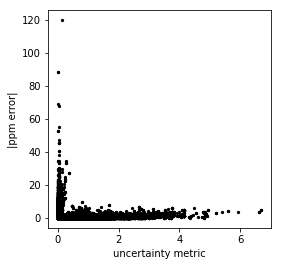

In [484]:
a = results_df
fig = pylab.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(a['std'], a.delta_abs, alpha=1, s=5, c='k')
ax.set_xlabel("uncertainty metric")
ax.set_ylabel("|ppm error|")

In [480]:
results_df.groupby('nuc').agg({'std' : ['mean', 'var']})

std          
         mean       var
nuc                    
13C  0.019652  0.000112
1H   0.473783  0.153452

In [500]:
TGT_THOLDS = np.array([0.1, 0.5, 0.8,  0.95, 0.9999])
nuc_tholds = {}
nuc_tholds_df = []

for nuc, nuc_df in results_df_test.groupby('nuc'):
    sorted_std = np.sort(nuc_df['std'])
    tholds = sorted_std[np.floor(len(sorted_std) * TGT_THOLDS).astype(int)]
    nuc_tholds[nuc] = tholds
    for f, t in zip(TGT_THOLDS, tholds):
        nuc_tholds_df.append({'nuc' : nuc, 'frac' : f, 'thold' :t })
nuc_tholds_df= pd.DataFrame(nuc_tholds_df)
nuc_tholds_df

,frac,nuc,thold
0,0.1000,13C,0.008594
1,0.5000,13C,0.017755
2,0.8000,13C,0.025944
3,0.9500,13C,0.037842
4,0.9999,13C,0.122359
5,0.1000,1H,0.196822
6,0.5000,1H,0.359011
7,0.8000,1H,0.576390
8,0.9500,1H,1.055400
9,0.9999,1H,4.443405


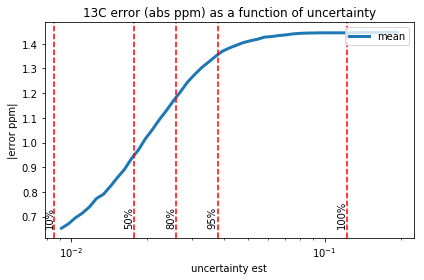

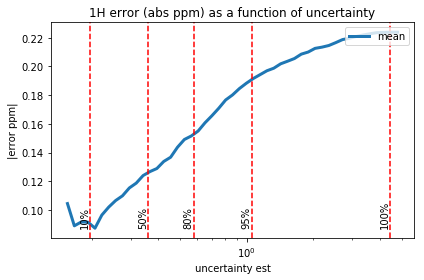

In [493]:
for gi, a in results_df_test.groupby('nuc'):

    fig = pylab.figure()
    res = []
    THOLDS = np.logspace(np.log10(np.min(a['std'])), 
                         np.log10(np.max(a['std'])), 50)

    for std_thold in  THOLDS:
        subset = a[a['std'] < std_thold].delta_abs
        res.append({'thold' : std_thold, 
                    'point_n' : len(subset),
                    'abs_err_mean' : subset.mean(), 
                    'abs_err_max' : subset.max(), 
                    
                   'abs_err_med' : subset.median()})
    thold_vals_df = pd.DataFrame(res)
    pylab.semilogx(thold_vals_df.thold, thold_vals_df.abs_err_mean, label='mean', linewidth=3)
    #pylab.semilogx(thold_vals_df.thold, thold_vals_df.abs_err_med, label='median', linewidth=3)
    
    pylab.xlabel("uncertainty est")
    pylab.ylabel("|error ppm|")
    for i, t in enumerate(TGT_THOLDS):
        
        pylab.axvline(nuc_tholds[gi][i], c='r', linestyle='--')
        pylab.text(nuc_tholds[gi][i],np.min(thold_vals_df.abs_err_mean) , 
                   "{:2.0f}%".format(t*100), rotation=90, ha='right', va='bottom')
    pylab.title(f"{gi} error (abs ppm) as a function of uncertainty")
    pylab.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(f"model validate many_nuc uncertainty.{gi}.pdf")

In [442]:
import metrics

In [494]:
# chunk this up by thold

result_tholds_df = []


for nuc in nuc_tholds.keys():
    a_all = results_df_test[results_df_test.nuc == nuc]

    for frac_thold, thold_val in zip(TGT_THOLDS, nuc_tholds[nuc]):
        a = a_all[a_all['std'] <= thold_val].copy()

        a['std_thold'] = std_thold
        a['frac_thold'] = frac_thold
        a['obs_per_nuc'] = len(a_all)
        result_tholds_df.append(a)
results_test_tholds_df = pd.concat(result_tholds_df)

In [495]:
import metrics
reload(metrics)
stats= results_test_tholds_df.groupby(['nuc', 'frac_thold']).apply(metrics.compute_stats,  mol_id_field='m_pos')
del stats['mol_n']
stats['data_frac'] = stats.n / len(results_df) 
stats

mol_MAE   mol_MSE  mean_abs       std        n  data_frac
nuc frac_thold                                                            
13C 0.1000      0.725083  0.787755  0.632533  1.148303   9753.0   0.021542
    0.5000      1.060711  1.292910  0.949778  1.681176  32046.0   0.070781
    0.8000      1.260909  1.613502  1.183433  2.150386  51273.0   0.113248
    0.9500      1.398840  1.827475  1.356983  2.481213  60887.0   0.134483
    0.9999      1.465282  1.929561  1.444488  2.620863  64085.0   0.141546
1H  0.1000      0.099468  0.107254  0.089212  0.237137   2643.0   0.005838
    0.5000      0.141873  0.164240  0.126426  0.246361  13210.0   0.029177
    0.8000      0.171891  0.212181  0.152386  0.321541  21135.0   0.046681
    0.9500      0.208256  0.277869  0.190539  0.426899  25100.0   0.055439
    0.9999      0.241571  0.339001  0.223837  0.511325  26415.0   0.058343

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


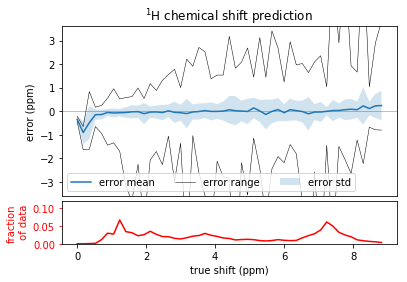

In [528]:
from matplotlib import gridspec
def plot_err_vs_ppm(tgt_df, nuc='13C', max_shift=None, max_shift_scale = 7.0):


    gs = gridspec.GridSpec(2, 1,
                           height_ratios=[4, 1], 

                           )

    gs.update(hspace=0.05)
    
    if max_shift is None:
        if nuc == '13C' :
            max_shift = 200.0
        else:
            max_shift = 9.0

    ppm_bins = np.linspace(0, max_shift, 52)
    tgt_df['bin'] = pd.cut(tgt_df.value, bins=ppm_bins, labels=False)

    a = tgt_df.groupby('bin').agg({'delta' : ['mean', 'std', 'count', 
                                              'min', 'max', 'quantile']}).reset_index()
    y_min = a[('delta', 'min')]
    y_max = a[('delta', 'max')]
    y_std = a[('delta', 'std')]
    y_mean = a[('delta', 'mean')]
    y_count = a[('delta', 'count')]

    fig = pylab.figure()
    ax = fig.add_subplot(gs[0])
    ax.plot(ppm_bins[:-1], y_mean, label='error mean')

    ax.fill_between(ppm_bins[:-1], y_mean - y_std, y_mean + y_std, alpha=0.2, label='error std')

    ax.plot(ppm_bins[:-1], y_min, c='k', linewidth=0.5, label='error range')
    ax.plot(ppm_bins[:-1], np.array(y_max), c='k', linewidth=0.5, label=None)

    #tgt_df.bin.value_counts()
    ax2 = fig.add_subplot(gs[1])

    ax2.plot(ppm_bins[:-1], y_count/np.sum(y_count), c='r')
    ax2.set_ylabel('fraction\n of data', color='r')
    ax2.tick_params('y', colors='r')
    ax2.set_ylim(0, 0.12)
    ax2.set_yticks([0.0, 0.05, 0.1])

    ax2.set_xlabel("true shift (ppm)")

    ax.axhline(0, c='k', zorder=-1, linewidth=0.5, alpha=0.5, label=None)
    #pylab.xlim(0, max_shift)
    
    ax.set_ylim(-max_shift*max_shift_scale, max_shift*max_shift_scale)
    if nuc == '13C':
        ax.set_title("$^{{13}}$C chemical shift prediction")
        
    else:
        ax.set_title("$^{{1}}$H chemical shift prediction")
        
    ax.set_ylabel("error (ppm)")
    ax.set_xticks([])
    ax.legend(loc='lower left', ncol=3)

    fig.tight_layout()

    #fig.savefig(f"model_validate.{checkpoint_i}.pdf")

    return fig, ax, ax2

plot_nuc = '1H'
subs = results_df_test[results_df_test.nuc == plot_nuc]
plot_frac = 0.95
plot_thold = nuc_tholds_df[(nuc_tholds_df.nuc == plot_nuc) & (nuc_tholds_df.frac == plot_frac)].iloc[0].thold
subs = subs[subs['std'] < plot_thold]
fig, _ , _= plot_err_vs_ppm(subs, nuc=plot_nuc, max_shift_scale=0.4)
fig.savefig(f"model validate many_nuc uncertainty_{plot_nuc}_{plot_frac}.pdf")

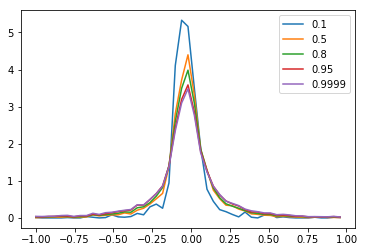

In [476]:
a = result_tholds_df[result_tholds_df.nuc == '1H']
for th, g in a.groupby('frac_thold'):
    bins = np.linspace(-1, 1, 50)
    b, _ = np.histogram(g.delta, bins=bins, density=True)
    pylab.plot(bins[:-1], b, label=th)
pylab.legend()

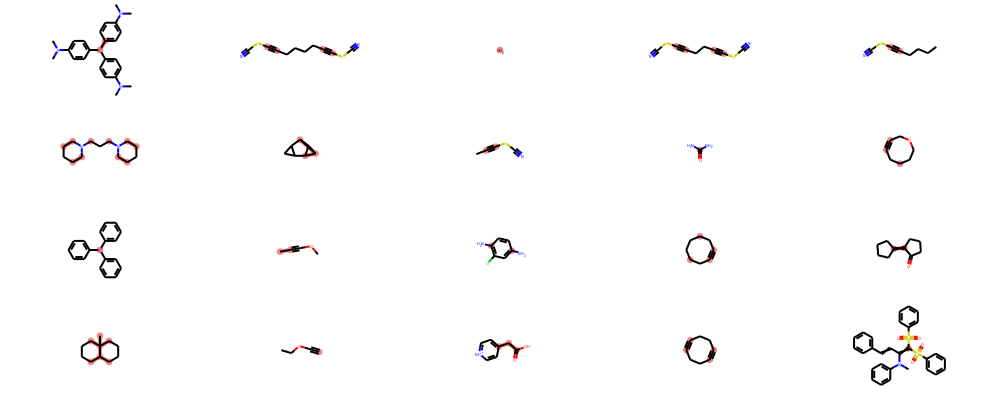

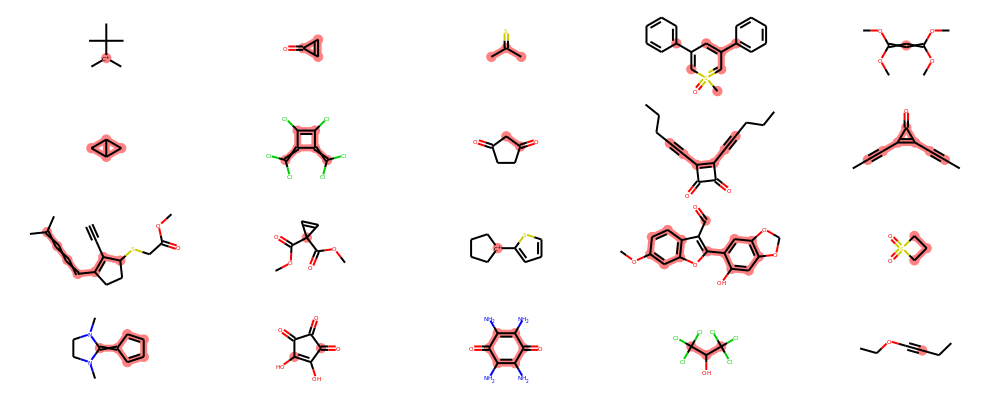

In [522]:
# let's look at the worst molecules
reload(metrics)
tgt_nuc = '13C'
for phase in ['train', 'test']:
    a = results_df[results_df.nuc == tgt_nuc]
    a = results_df[results_df.phase == phase]
    
    b = a.groupby('molecule_id').agg({'delta_abs' : 'mean'}).sort_values('delta_abs', ascending=False)
    mol_id_plot = b.index.values[:20]
    
    mol_to_plot = []
    atoms_to_highlight = []
    for mol_id in mol_id_plot:
        tgt_shifts = a[a.molecule_id == mol_id]
        worst = tgt_shifts[tgt_shifts.delta_abs > 5]
        atoms_to_highlight.append(list(worst.atom_idx))
        m = Chem.RemoveHs(tgt_df[tgt_df.molecule_id == mol_id].iloc[0].rdmol)

        Chem.AllChem.Compute2DCoords(m)
        mol_to_plot.append(m)
    img= Chem.Draw.MolsToGridImage(mol_to_plot, molsPerRow=5, highlightAtomLists=atoms_to_highlight, subImgSize=(200, 100),)
    display(img)

In [417]:
mol_to_plot = []
atoms_to_highlight = []
for mol_id in mol_id_plot:
    tgt_shifts = a[a.molecule_id == mol_id]
    worst = tgt_shifts[tgt_shifts.delta_abs > 5]  
    atoms_to_highlight.append(list(worst.atom_idx))
    m = Chem.RemoveHs(tgt_df[tgt_df.molecule_id == mol_id].iloc[0].rdmol)
    
    Chem.AllChem.Compute2DCoords(m)
    mol_to_plot.append(m)

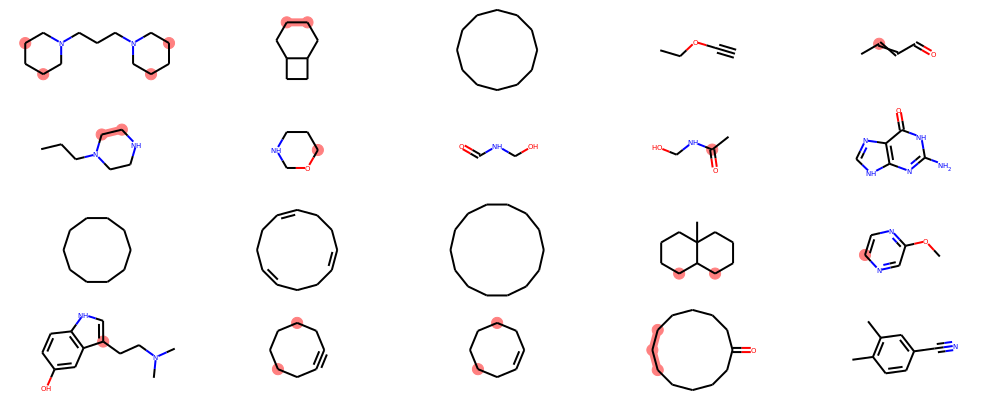

In [418]:
Chem.Draw.MolsToGridImage(mol_to_plot, molsPerRow=5, highlightAtomLists=atoms_to_highlight, subImgSize=(200, 100),)

In [ ]:
m = Chem.RemoveHs(test_df.iloc[1192].rdmol)
Chem.AllChem.Compute2DCoords(m)
m

# Kwan15 Natural Product validation

In [194]:
# try with naturalprod

kwan15_mol_df = pickle.load(open("../../nmrabinitio/data/kwan15_naturalprod.mol.pickle", 'rb'))

def clean(mol):
    Chem.SanitizeMol(mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, 
                     catchErrors=True)
    mol.UpdatePropertyCache()
    Chem.SetAromaticity(mol)

            
kwan15_mol_df.rdmol.apply(lambda m : Chem.SanitizeMol(m))
kwan15_mol_df.head()
kwan15_mol_df['atom_n'] = kwan15_mol_df.rdmol.apply(clean)
kwan15_true_shifts_df = pd.read_feather("../../nmrabinitio/data/kwan15_naturalprod.shifts.feather")
kwan15_true_shifts_df.head()


,index,atom_idx,nuc,value,mol_name,molecule_id
0,0,30,1H,1.54,myrrhine,0
1,1,33,1H,1.54,myrrhine,0
2,2,29,1H,1.04,myrrhine,0
3,3,32,1H,1.04,myrrhine,0
4,4,31,1H,1.47,myrrhine,0


In [195]:
allres = []
for mol_id, g in kwan15_true_shifts_df.groupby('molecule_id'):
    res = []
    for nuc in ['13C', '1H']:
        nuc_res = {}
        for row_i, row in g[g.nuc == nuc].iterrows():
            nuc_res[row.atom_idx] = row.value
        res.append(nuc_res)
    allres.append({'molecule_id': mol_id, 'value' : res})
kwan15_results_shift_df = pd.DataFrame(allres).set_index('molecule_id')

In [196]:
a = kwan15_mol_df.join(kwan15_results_shift_df, on='molecule_id')
kwan15_results_df = model.pred(a.rdmol.tolist(),a.value.tolist())
kwan15_results_df['delta'] = kwan15_results_df.value - kwan15_results_df.est
kwan15_results_df['delta_abs'] = np.abs(kwan15_results_df.delta)
kwan15_results_df['delta_sq'] = np.abs(kwan15_results_df.delta**2)

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


In [210]:
b = kwan15_results_df[kwan15_results_df.nuc == '13C']
b.sort_values('delta_abs', ascending=False).head(12)

,atom_idx,est,i_batch,m_pos,nuc,nuc_i,std,std_out,value,delta,delta_abs,delta_sq
280,31,37.536957,0,7,13C,0,0.043304,True,128.399994,90.863037,90.863037,8256.091513
317,0,46.936401,0,8,13C,0,0.010646,True,129.500000,82.563599,82.563599,6816.747819
322,5,55.450027,0,8,13C,0,0.016955,True,137.699997,82.249969,82.249969,6765.057480
267,3,55.977821,0,7,13C,0,0.017935,True,136.399994,80.422173,80.422173,6467.725837
229,4,159.807480,0,6,13C,0,0.034166,True,144.500000,-15.307480,15.307480,234.318940
106,4,159.807480,0,3,13C,0,0.034166,True,144.500000,-15.307480,15.307480,234.318940
464,4,62.560669,0,11,13C,0,0.059814,True,48.299999,-14.260670,14.260670,203.366701
543,4,60.601357,0,13,13C,0,0.049192,True,47.900002,-12.701355,12.701355,161.324418
228,3,111.402145,0,6,13C,0,0.022765,True,124.000000,12.597855,12.597855,158.705941
105,3,111.402145,0,3,13C,0,0.022765,True,124.000000,12.597855,12.597855,158.705941


In [217]:
b = a.loc[7]
b

filename                                            vinigrol.dat
mol_name                                                vinigrol
molecule_id                                                    7
rdmol           <rdkit.Chem.rdchem.Mol object at 0x7f562e1dec00>
atom_n                                                      None
value          [{0: 67.9, 3: 136.4, 31: 128.4, 29: 45.8, 27: ...
Name: 7, dtype: object

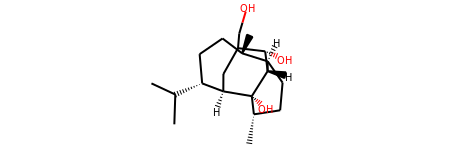

In [218]:
Chem.RemoveHs(b.rdmol)

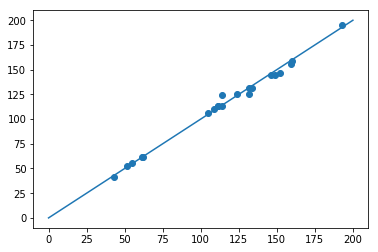

In [222]:
a = kwan15_results_df[kwan15_results_df.m_pos == 3]
a = a[a.nuc == '13C']
pylab.scatter(np.sort(a.est), np.sort(a.value))
pylab.plot([0, 200], [0, 200])

In [193]:
kwan15_results_df = kwan15_results_df[~kwan15_results_df.m_pos.isin([7, 8])]
TGT_THOLDS = np.array([0.1, 0.5, 0.8,  0.95, 0.9999])
nuc_tholds = {}
for nuc, nuc_df in kwan15_results_df.groupby('nuc'):
    sorted_std = np.sort(nuc_df['std'])
    tholds = sorted_std[np.floor(len(sorted_std) * TGT_THOLDS).astype(int)]
    nuc_tholds[nuc] = tholds
    
# chunk this up by thold

result_tholds_df = []


for nuc in nuc_tholds.keys():
    a_all = kwan15_results_df[kwan15_results_df.nuc == nuc]

    for frac_thold, thold_val in zip(TGT_THOLDS, nuc_tholds[nuc]):
        a = a_all[a_all['std'] <= thold_val].copy()

        a['std_thold'] = std_thold
        a['frac_thold'] = frac_thold
        a['obs_per_nuc'] = len(a_all)
        result_tholds_df.append(a)
result_tholds_df = pd.concat(result_tholds_df)

stats= result_tholds_df.groupby(['nuc', 'frac_thold']).apply(metrics.compute_stats,  mol_id_field='m_pos')
del stats['mol_n']
stats['data_frac'] = stats.n / len(kwan15_results_df) 
stats

mol_MAE   mol_MSE  mean_abs       std      n  data_frac
nuc frac_thold                                                          
13C 0.1000      2.398973  2.470751  1.831302  3.317991   30.0   0.049020
    0.5000      1.508598  2.354290  1.516670  2.863417  143.0   0.233660
    0.8000      2.014412  2.894517  1.910577  3.426677  231.0   0.377451
    0.9500      2.058469  2.978683  2.021630  3.420387  272.0   0.444444
    0.9999      2.205295  3.196453  2.165828  3.632689  285.0   0.465686
1H  0.1000      0.103725  0.109241  0.098534  0.119339   37.0   0.060458
    0.5000      0.195306  0.262464  0.176260  0.258389  164.0   0.267974
    0.8000      0.197119  0.277367  0.197183  0.307296  263.0   0.429739
    0.9500      0.214375  0.294928  0.215094  0.322893  311.0   0.508170
    0.9999      0.229303  0.309206  0.233882  0.344358  327.0   0.534314

(-20, 200)

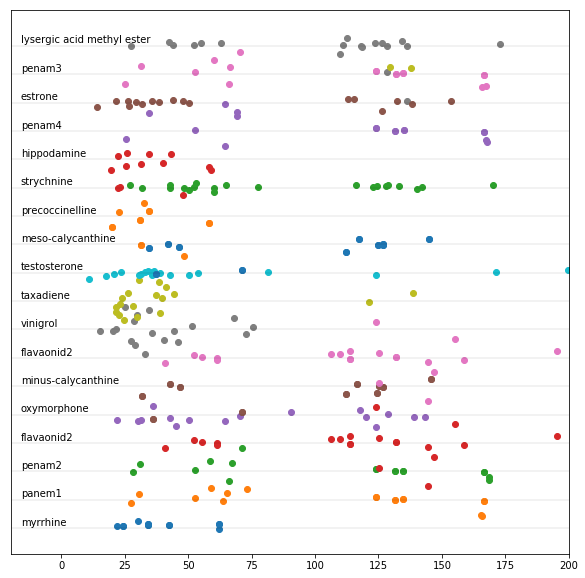

In [253]:
a = kwan15_results_df[kwan15_results_df.nuc == '13C']

fig = pylab.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
for mol_i, row in a.groupby('m_pos'):
    offset = mol_i * 10
    ax.scatter(row['value'].values , 
                  row['delta'].values+ offset)
    ax.axhline(offset, c='k', linewidth=0.1)
    ax.text(-16, offset+1, kwan15_mol_df.iloc[mol_i].mol_name)
    #pylab.plot([0, 200], [0, 200])
ax.set_yticks([])
ax.set_xlim(-20, 200)


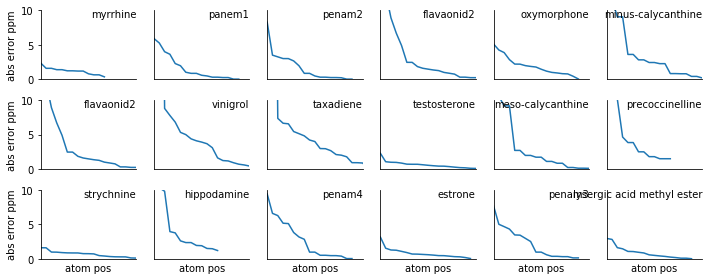

In [434]:
import matplotlib.gridspec 


a = kwan15_results_df[kwan15_results_df.nuc == '13C']

fig = pylab.figure(figsize=(10, 4))
gs = matplotlib.gridspec.GridSpec(3, 6)

for mol_i, row in a.groupby('m_pos'):
    ax = fig.add_subplot(gs[mol_i])

    offset = mol_i * 10
    ax.plot(np.sort(row['delta_abs'])[::-1])
    ax.set_xlim(0, 18)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    sns.despine()
            
    #ax.axhline(offset, c='k', linewidth=0.1)
    ax.text(18, 9, kwan15_mol_df.iloc[mol_i].mol_name, ha='right')
    #ax.set_title(kwan15_mol_df.iloc[mol_i].mol_name)
    
    if mol_i % 6 != 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel("abs error ppm")
    if mol_i >= 12:
        ax.set_xlabel("atom pos")
    #pylab.plot([0, 200], [0, 200])
fig.tight_layout()